model1:cv0.2728  
model1 ver.1.1:0.2727  
model1 ver.1.2:0.2717  
model1 ver.1.3:0.2714

In [1]:
import tensorflow as tf; print(tf.__version__)

2.3.0


In [2]:
import numpy as np 
import pandas as pd 
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
import category_encoders as ce
%matplotlib inline

from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)

from catboost import CatBoost
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm

import os
from glob import glob

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import shap
import gc

from optuna.integration import _lightgbm_tuner as lgb_tuner
import optuna
from collections import Counter
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

/Users/kengofujii/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/kengofujii/.local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
#TRAIN_DIR = '../train/'

paths = glob('../train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)

test_df = pd.read_csv("../test.csv")
submission = pd.read_csv("../sample_submission.csv")

In [4]:
train_df_defaut = train_df.copy()
test_df_defaut = test_df.copy()

In [5]:
train_df.shape

(637351, 28)

In [6]:
test_df.shape

(19466, 27)

In [7]:
submission.shape

(19466, 2)

In [8]:
# add_data plus
## jinkou_data

add_data = pd.read_csv("../add_data/jinkou_data.csv")
add_data = add_data.drop(["Unnamed: 0", "都道府県名"], axis=1)
add_data.rename(columns={"都道府県・市区町村名":"市区町村名"},inplace=True)
add_data.drop_duplicates("市区町村名", inplace=True)
#add_data_train = add_data[add_data["市区町村名"].isin(train_df["市区町村名"].unique())]
#add_data_test = add_data[add_data["市区町村名"].isin(test_df["市区町村名"].unique())]

# add_data lines
## 申請が必要なので、後日
### https://ekidata.jp/
"""
stations_data = pd.read_csv("../add_data/station20200619free.csv")
lines_data = pd.read_csv("../add_data/line20200619free.csv")
tmp = pd.merge(stations_data, lines_data, on="line_cd", how="left")
lines_name = tmp[["station_name", "line_name"]]
lines_name.rename(columns={"station_name":"最寄駅：名称"},inplace=True)
lines_name.drop_duplicates("最寄駅：名称", inplace=True)"""

# 地価データを追加
## 精度が向上するか確認。
### 向上する場合は、申請を後日行う
tika = pd.read_csv("../add_data/tika_data.csv", encoding="SHIFT-JIS")
pickup_l = ["所在地コード", 'Ｓ５８価格', 'Ｓ５９価格', 'Ｓ６０価格', 'Ｓ６１価格', 'Ｓ６２価格',
       'Ｓ６３価格', 'Ｈ１価格', 'Ｈ２価格', 'Ｈ３価格', 'Ｈ４価格', 'Ｈ５価格', 'Ｈ６価格', 'Ｈ７価格', 'Ｈ８価格',
       'Ｈ９価格', 'Ｈ１０価格', 'Ｈ１１価格', 'Ｈ１２価格', 'Ｈ１３価格', 'Ｈ１４価格', 'Ｈ１５価格', 'Ｈ１６価格',
       'Ｈ１７価格', 'Ｈ１８価格', 'Ｈ１９価格', 'Ｈ２０価格', 'Ｈ２１価格', 'Ｈ２２価格', 'Ｈ２３価格', 'Ｈ２４価格',
       'Ｈ２５価格', 'Ｈ２６価格', 'Ｈ２７価格', 'Ｈ２８価格', 'Ｈ２９価格', 'Ｈ３０価格', 'Ｈ３１価格',
      ]

tika_data = tika.groupby("所在地コード", as_index=False).mean()[pickup_l]
tika_data.rename(columns={"所在地コード":"市区町村コード"},inplace=True)

train_df = pd.merge(train_df, add_data, on="市区町村名", how="left")
test_df = pd.merge(test_df, add_data, on="市区町村名", how="left")

train_df = pd.merge(train_df, tika_data, on="市区町村コード", how="left")
test_df = pd.merge(test_df, tika_data, on="市区町村コード", how="left")

#train_df = pd.merge(train_df, lines_name, on="最寄駅：名称", how="left")
#test_df = pd.merge(test_df, lines_name, on="最寄駅：名称", how="left")

In [9]:
train_df.shape

(637351, 110)

In [10]:
test_df.shape

(19466, 109)

# Proprecess

In [11]:
def convert_nearest(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

def normarized_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

def convert_year(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

def get_nearest(input_df):
    output_df = pd.DataFrame()
    output_df["最寄駅：距離（分）"] = input_df["最寄駅：距離（分）"].apply(lambda x: convert_nearest(x))
    return output_df

def get_area(input_df):
    output_df = pd.DataFrame()
    output_df["面積（㎡）"] = input_df["面積（㎡）"].apply(lambda x: normarized_area(x))
    return output_df

def get_year(input_df):
    output_df = pd.DataFrame()
    output_df["建築年"] = input_df["建築年"].apply(lambda x:convert_year(x))
    return output_df

def house_age(input_df):
    output_df = pd.DataFrame()
    output_df["築年数"] = 2020 - (input_df["建築年"].apply(lambda x:convert_year(x)))
    return output_df

def agg_Arithmetic_combinations_area(input_df):
    output_df = pd.DataFrame()
    output_df["面積（㎡）_容積率（％）"] = (input_df["面積（㎡）"].apply(lambda x: normarized_area(x)))* input_df["容積率（％）"]
    output_df["面積（㎡）_容積率（％）"] = output_df["面積（㎡）_容積率（％）"].apply(lambda x: x/100)
    return output_df

def sq_kp(input_df):
    output_df = pd.DataFrame()
    output_df["面積（㎡）_建ぺい率（％）"] = (input_df["面積（㎡）"].apply(lambda x: normarized_area(x)))* input_df["建ぺい率（％）"]
    output_df["面積（㎡）_建ぺい率（％）"] = output_df["面積（㎡）_建ぺい率（％）"].apply(lambda x: x/100)
    return output_df

def torihiki(input_df):
    output_df = pd.DataFrame()
    output_df["取引時点_何年前"] = input_df['取引時点'].apply(lambda x: 2020-int(x[:4]))
    return output_df

def get_agg_pref(input_df):
    cols = '都道府県名'
    
    input_df["最寄駅：距離（分）"] = input_df["最寄駅：距離（分）"].apply(lambda x: convert_nearest(x))
    input_df["面積（㎡）"] = input_df["面積（㎡）"].apply(lambda x: normarized_area(x))
    
    # 掛け合わせた値もいれる2020_01_31
    input_df["面積（㎡）_建ぺい率（％）"] = input_df["面積（㎡）"] * input_df["建ぺい率（％）"]/100
    input_df["面積（㎡）_容積率（％）"] = input_df["面積（㎡）"] * input_df["容積率（％）"]/100
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(input_df,
                                                group_key=cols,
                                                group_values=['最寄駅：距離（分）',
                                                              '面積（㎡）', '建ぺい率（％）', '容積率（％）', "面積（㎡）_建ぺい率（％）", "面積（㎡）_容積率（％）"],
                                                agg_methods=['count', 'mean', 'min', 'max'],
                                               )
    return output_df[agg_cols]

def get_agg_area(input_df):
    cols = '市区町村名'
    
    input_df["最寄駅：距離（分）"] = input_df["最寄駅：距離（分）"].apply(lambda x: convert_nearest(x))
    input_df["面積（㎡）"] = input_df["面積（㎡）"].apply(lambda x: normarized_area(x))
    
    # 掛け合わせた値もいれる2020_01_31
    input_df["面積（㎡）_建ぺい率（％）"] = input_df["面積（㎡）"] * input_df["建ぺい率（％）"]/100
    input_df["面積（㎡）_容積率（％）"] = input_df["面積（㎡）"] * input_df["容積率（％）"]/100
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(input_df,
                                                group_key=cols,
                                                group_values=['最寄駅：距離（分）',
                                                              '面積（㎡）', '建ぺい率（％）', '容積率（％）', "面積（㎡）_建ぺい率（％）", "面積（㎡）_容積率（％）"],
                                                agg_methods=['count', 'mean', 'min', 'max'],
                                               )
    return output_df[agg_cols]

def get_agg_district(input_df):
    cols = '地区名'
    
    input_df["最寄駅：距離（分）"] = input_df["最寄駅：距離（分）"].apply(lambda x: convert_nearest(x))
    input_df["面積（㎡）"] = input_df["面積（㎡）"].apply(lambda x: normarized_area(x))
    
    # 掛け合わせた値もいれる2020_01_31
    input_df["面積（㎡）_建ぺい率（％）"] = input_df["面積（㎡）"] * input_df["建ぺい率（％）"]/100
    input_df["面積（㎡）_容積率（％）"] = input_df["面積（㎡）"] * input_df["容積率（％）"]/100
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(input_df,
                                                group_key=cols,
                                                group_values=['最寄駅：距離（分）',
                                                              '面積（㎡）', '建ぺい率（％）', '容積率（％）',"面積（㎡）_建ぺい率（％）", "面積（㎡）_容積率（％）",],
                                                agg_methods=['count', 'mean', 'min', 'max'],
                                               )
    return output_df[agg_cols]

def get_agg_moyori(input_df):
    cols = '最寄駅：名称'
    
    input_df["最寄駅：距離（分）"] = input_df["最寄駅：距離（分）"].apply(lambda x: convert_nearest(x))
    input_df["面積（㎡）"] = input_df["面積（㎡）"].apply(lambda x: normarized_area(x))
    
    # 掛け合わせた値もいれる2020_01_31
    input_df["面積（㎡）_建ぺい率（％）"] = input_df["面積（㎡）"] * input_df["建ぺい率（％）"]/100
    input_df["面積（㎡）_容積率（％）"] = input_df["面積（㎡）"] * input_df["容積率（％）"]/100
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(input_df,
                                                group_key=cols,
                                                group_values=['最寄駅：距離（分）',
                                                              '面積（㎡）', '建ぺい率（％）', '容積率（％）',"面積（㎡）_建ぺい率（％）", "面積（㎡）_容積率（％）",
                                                              'Ｓ５８価格', 'Ｓ５９価格', 'Ｓ６０価格', 'Ｓ６１価格', 'Ｓ６２価格',
                                                              'Ｓ６３価格', 'Ｈ１価格', 'Ｈ２価格', 'Ｈ３価格', 'Ｈ４価格', 'Ｈ５価格', 'Ｈ６価格', 'Ｈ７価格', 'Ｈ８価格',
                                                              'Ｈ９価格', 'Ｈ１０価格', 'Ｈ１１価格', 'Ｈ１２価格', 'Ｈ１３価格', 'Ｈ１４価格', 'Ｈ１５価格', 'Ｈ１６価格',
                                                              'Ｈ１７価格', 'Ｈ１８価格', 'Ｈ１９価格', 'Ｈ２０価格', 'Ｈ２１価格', 'Ｈ２２価格', 'Ｈ２３価格', 'Ｈ２４価格',
                                                              'Ｈ２５価格', 'Ｈ２６価格', 'Ｈ２７価格', 'Ｈ２８価格', 'Ｈ２９価格', 'Ｈ３０価格', 'Ｈ３１価格'],
                                                agg_methods=['count', 'mean', 'min', 'max'],
                                               )
    return output_df[agg_cols]

def get_agg_moyori_default(input_df):
    cols = '最寄駅：名称'
    
    input_df["最寄駅：距離（分）"] = input_df["最寄駅：距離（分）"].apply(lambda x: convert_nearest(x))
    input_df["面積（㎡）"] = input_df["面積（㎡）"].apply(lambda x: normarized_area(x))
    
    # 掛け合わせた値もいれる2020_01_31
    input_df["面積（㎡）_建ぺい率（％）"] = input_df["面積（㎡）"] * input_df["建ぺい率（％）"]/100
    input_df["面積（㎡）_容積率（％）"] = input_df["面積（㎡）"] * input_df["容積率（％）"]/100
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(input_df,
                                                group_key=cols,
                                                group_values=['最寄駅：距離（分）',
                                                              '面積（㎡）', '建ぺい率（％）', '容積率（％）',"面積（㎡）_建ぺい率（％）", "面積（㎡）_容積率（％）",
                                                              ],
                                                agg_methods=['count', 'mean', 'min', 'max'],
                                               )
    return output_df[agg_cols]

def get_agg_purchase(input_df):
    cols = '今後の利用目的'
    
    input_df["最寄駅：距離（分）"] = input_df["最寄駅：距離（分）"].apply(lambda x: convert_nearest(x))
    input_df["面積（㎡）"] = input_df["面積（㎡）"].apply(lambda x: normarized_area(x))
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(input_df,
                                                group_key=cols,
                                                group_values=['最寄駅：距離（分）',
                                                              '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                                                agg_methods=['count', 'mean', 'min', 'max'],
                                               )
    return output_df[agg_cols]

def covert_district(input_df):
    output_df =pd.DataFrame()
    
    input_df["最寄駅：距離（分）"] = input_df["最寄駅：距離（分）"].apply(lambda x: convert_nearest(x))
    output_df["距離"] = input_df["最寄駅：距離（分）"] * 80
    
    return output_df

def encode_rooms(input_df):
    output_df = pd.DataFrame()
    output_df["面積（㎡）"] = input_df["面積（㎡）"].apply(lambda x: normarized_area(x))
    
    output_df["L"] = input_df['間取り'].map(lambda x: 1 if 'Ｌ' in str(x) else 0)
    output_df["D"] = input_df['間取り'].map(lambda x: 1 if 'D' in str(x) else 0)
    output_df["K"] = input_df['間取り'].map(lambda x: 1 if 'K' in str(x) else 0)
    output_df["R"] = input_df['間取り'].map(lambda x: 1 if 'R' in str(x) else 0)
    output_df["S"] = input_df['間取り'].map(lambda x: 1 if 'S' in str(x) else 0)
    output_df["Maisonette"] = input_df['間取り'].map(lambda x: 1 if 'メゾネット' in str(x) else 0)
    output_df["OpenFloor"] = input_df['間取り'].map(lambda x: 1 if 'オープンフロア' in str(x) else 0)
    output_df["Studio"] = input_df['間取り'].map(lambda x: 1 if 'スタジオ' in str(x) else 0)
    
    output_df['Special'] = output_df['Maisonette'] + output_df['OpenFloor'] + output_df['Studio'] 
    output_df['RoomNum'] = input_df['間取り'].map(lambda x: re.sub("\\D", "", str(x)))
    output_df['RoomNum'] = output_df['RoomNum'].map(lambda x:int(x) if x!='' else 0)
    
    output_df['TotalRoomNum'] = output_df[['L', 'D', 'K', 'S', 'R', 'RoomNum']].sum(axis=1)
    output_df['RoomNumRatio'] = output_df['RoomNum'] / output_df['TotalRoomNum']
    
    output_df["area_per_rooms"] = output_df["面積（㎡）"]/output_df["TotalRoomNum"]
    output_df=output_df.drop("面積（㎡）", axis=1)
    
    return output_df


def create_continuous_features(input_df):
    use_columns = [
        # 連続変数
        "市区町村コード",
        "建ぺい率（％）",
        "容積率（％）"  ,
        '総人口',
        '組替人口',
        '人口増減数',
        '人口増減率', 
        '面積',
        '人口密度',
        '平均年齢',
        '年齢中位数',
       '15歳未満人口',
        '15～64歳人口',
        '65歳以上人口',
        '15歳未満人口割合',
        '15～64歳人口割合',
       '65歳以上人口割合',
        '総数人口＿男',
        '15歳未満人口_男',
        '15～64歳人口_男',
        '65歳以上人口_男',
       '15歳未満_男人口割合',
        '15～64歳_男人口割合',
        '65歳以上_男人口割合',
        '総数人口_女',
        '15歳未満_女人口',
       '15～64歳_女人口',
        '65歳以上_女人口',
        '15歳未満_女人口割合',
        '15～64歳_女人口割合',
        '65歳以上_女人口割合',
       '人口性比', '日本人',
        '外国人',
        '世帯総数',
        '一般世帯',
        '施設等の世帯',
        '平成22年組替世帯総数',
        '一般世帯数',
       '一般世帯数うち核家族世帯',
        '一般世帯数うち夫婦のみの世帯',
        '一般世帯数うち夫婦と子供から成る世帯',
       '一般世帯数うち男親と子供から成る世帯',
        '一般世帯数うち女親と子供から成る世帯',
        '一般世帯数うち単独世帯',
       'うち65歳以上の高齢単身者世帯',
        '高齢夫婦世帯',
        '３世代世帯',
        'Ｓ５８価格', 'Ｓ５９価格', 'Ｓ６０価格', 'Ｓ６１価格', 'Ｓ６２価格',
       'Ｓ６３価格', 'Ｈ１価格', 'Ｈ２価格', 'Ｈ３価格', 'Ｈ４価格', 'Ｈ５価格', 'Ｈ６価格', 'Ｈ７価格', 'Ｈ８価格',
       'Ｈ９価格', 'Ｈ１０価格', 'Ｈ１１価格', 'Ｈ１２価格', 'Ｈ１３価格', 'Ｈ１４価格', 'Ｈ１５価格', 'Ｈ１６価格',
       'Ｈ１７価格', 'Ｈ１８価格', 'Ｈ１９価格', 'Ｈ２０価格', 'Ｈ２１価格', 'Ｈ２２価格', 'Ｈ２３価格', 'Ｈ２４価格',
       'Ｈ２５価格', 'Ｈ２６価格', 'Ｈ２７価格', 'Ｈ２８価格', 'Ｈ２９価格', 'Ｈ３０価格', 'Ｈ３１価格',
    ]
    output_df = input_df[use_columns]
    return output_df

def create_continuous_features_default(input_df):
    use_columns = [
        # 連続変数
        "市区町村コード",
        "建ぺい率（％）",
        "容積率（％）"  ,
    ]
    output_df = input_df[use_columns]
    return output_df

In [12]:
# 前処理

# BaseBlock 
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()

# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")
    
# CountEncoding
## 今回はto_featureでtrain, testを結合する
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
    
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])

    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")
    
# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")


In [13]:
# 取引時点に関しては、train とtestで重複がないので、その分を評価していかないといけない
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)

    cols = [
        "都道府県名",
        "市区町村名",
        "地区名",
        "最寄駅：名称", 
        "間取り", 
        "建物の構造",
        "用途", 
        "今後の利用目的",
        "都市計画",
        "改装",
        "取引の事情等",
    ]
    encoder = CountEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df

def get_oe_features(input_df):
    _input_df = pd.concat([input_df])
    cols = [
        "都道府県名",
        "市区町村名",
        "地区名", 
        "最寄駅：名称",
        "間取り"
    ]
    encoder = OrdinalEncodingBlock(cols=cols)
    output_df = encoder.fit(input_df)
    return output_df


def get_ohe_features(input_df):
    cols = [
        "建物の構造",
        "今後の利用目的", 
        "間取り",
        "用途",
        "改装",
        "取引の事情等",
    ]
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(input_df)
    return output_df

In [14]:
# propress
def to_features(train, test):
    input_df = pd.concat([train, test]).reset_index(drop=True)

    processes = [
        get_oe_features,
        get_ce_features,
        get_ohe_features,
        get_nearest,
        get_area,
        get_year,
        house_age,
        agg_Arithmetic_combinations_area,
        torihiki,
        get_agg_area,
        sq_kp,
        encode_rooms,
        get_agg_pref,
        get_agg_district,
        get_agg_moyori,
        get_agg_purchase,
        covert_district,
        create_continuous_features
    ]

    output_df = pd.DataFrame()
    for func in tqdm(processes):
        _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)

    train_x = output_df.iloc[:len(train)] 
    test_x = output_df.iloc[len(train):].reset_index(drop=True)
    return train_x, test_x


# 追加データなしの場合の前処理実施関数
def to_features_defalut(train, test):
    input_df = pd.concat([train, test]).reset_index(drop=True)

    processes = [
        get_oe_features,
        get_ce_features,
        get_ohe_features,
        get_nearest,
        get_area,
        get_year,
        house_age,
        agg_Arithmetic_combinations_area,
        torihiki,
        get_agg_area,
        sq_kp,
        encode_rooms,
        get_agg_pref,
        get_agg_district,
        get_agg_moyori_default,
        get_agg_purchase,
        covert_district,
        create_continuous_features_default
    ]

    output_df = pd.DataFrame()
    for func in tqdm(processes):
        _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)

    train_x = output_df.iloc[:len(train)] 
    test_x = output_df.iloc[len(train):].reset_index(drop=True)
    return train_x, test_x

In [15]:
class HorizontalDisplay:
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        template = '<div style="float: left; padding: 10px;">{0}</div>'
        return "\n".join(template.format(arg._repr_html_())
                         for arg in self.args)

In [16]:
target_data = "取引価格（総額）_log" 

train_x, test_x = to_features(train_df, test_df)
train_ys = train_df[target_data]



100%|██████████| 18/18 [07:11<00:00, 23.99s/it]


In [17]:
train_x_default, test_x_default = to_features_defalut(train_df_defaut, test_df_defaut)

100%|██████████| 18/18 [01:47<00:00,  6.00s/it]


In [18]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

# Target Encoding

TargetEncodingに関しては、有無でモデルを作成してく予定なので、function内に関数処理をさせないようにする。 

In [19]:
"""from nyaggle.feature.category_encoder import TargetEncoder
fold = KFold(n_splits=5, shuffle=True, random_state=71)

tmp_y = train_ys.copy()
te = TargetEncoder(cv=fold, groups=train_df['地区名'])
X = te.fit_transform(train_df.drop("取引価格（総額）_log", axis=1), tmp_y)
X_test = te.transform(test_df)"""

fold = KFold(n_splits=5, shuffle=True, random_state=71)

encoder = TargetEncoder(
    input_cols=["都道府県名",
        "市区町村名",
        "地区名", 
        "最寄駅：名称",
        "間取り"], 
    target_col="取引価格（総額）_log",
    fold=fold,
    output_suffix="_re"
    )

te_cols = ["都道府県名_re",
        "市区町村名_re",
        "地区名_re", 
        "最寄駅：名称_re",
        "間取り_re"]

encoded_train = encoder.fit_transform(train_df)
encode_test = encoder.transform(test_df)

encoded_train = encoded_train[te_cols]
encoded_test = encode_test[te_cols]

In [20]:
train_x_te = pd.concat([train_x, encoded_train], axis=1)
test_x_te = pd.concat([test_x, encoded_test], axis=1)

In [21]:
train_x.shape

(637351, 500)

In [22]:
test_x.shape

(19466, 500)

In [23]:
len(train_ys)

637351

In [24]:
submission.shape

(19466, 2)

In [25]:
train_x_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637351 entries, 0 to 637350
Columns: 505 entries, OE_都道府県名 to 間取り_re
dtypes: float64(341), int64(164)
memory usage: 2.4 GB


# Training

In [26]:
# ligthGBM
def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_absolute_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} MAE: {metric_func(y_valid, pred_i) :.4f}')

    score = metric_func(y, oof_pred) 
    print('FINISHED | Whole MAE: {:.4f}'.format(score))
    return oof_pred, models


# XGB

def fit_xgb(X, y, cv, params: dict=None, verbose: int=50):
    metric_func = mean_absolute_error
    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        model_xgb = xgb.XGBRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            model_xgb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)],verbose=-1)
            
        #print(model_xgb.best_score())
        
        pred_i = model_xgb.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(model_xgb)

        print(f'Fold {i} MAE: {metric_func(y_valid, pred_i) :.4f}')

    score = metric_func(y, oof_pred) 
    print('FINISHED | Whole MAE: {:.4f}'.format(score))
    return oof_pred, models

# Catboost
def fit_cb(X, y, cv, params: dict=None, verbose: int=50):
    metric_func = mean_absolute_error
    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        train_pool = Pool(x_train, label = y_train)
        valid_pool = Pool(x_valid, label = y_valid)
        
        model_cb = CatBoostRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            model_cb.fit(train_pool,
              # valid_data
              eval_set = valid_pool,
              use_best_model = True,
              silent = True,
              plot = False)
            
        print(model_cb.get_best_score())
        
        pred_i = model_cb.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(model_cb)

        print(f'Fold {i} MAE: {metric_func(y_valid, pred_i) :.4f}')

    score = metric_func(y, oof_pred) 
    print('FINISHED | Whole MAE: {:.4f}'.format(score))
    return oof_pred, models

In [27]:

EARLY_STOPPING_ROUNDS = 10
VERBOSE_EVAL = 10000
LGB_ROUND_NUM = 10000

def fit_lgbm2(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_absolute_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_valid = lgb.Dataset(x_valid, y_valid)

        #clf = lgbm.LGBMRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            lgb_model = lgb_tuner.train(params, lgb_train,
                          num_boost_round=LGB_ROUND_NUM,
                          valid_names=["train", "valid"],
                          valid_sets=[lgb_train, lgb_valid],
                          early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                          verbose_eval=VERBOSE_EVAL)
            
            
            """clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)"""

        pred_i = lgb_model.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(lgb_model)

        print(f'Fold {i} MAE: {metric_func(y_valid, pred_i) :.4f}')

    score = metric_func(y, oof_pred) 
    print('FINISHED | Whole MAE: {:.4f}'.format(score))
    return oof_pred, models

# optuna(best param)

In [28]:
def fit_lgbm_param_optuna(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_absolute_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(clf)

    score = metric_func(y, oof_pred) 
    return score

def objective(trial):
    
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    cv = list(fold.split(train_x, train_ys))
    optuna_paramas_lgb = {
        'num_leaves': trial.suggest_int('num_leaves', 32, 512),
        'boosting_type': 'gbdt',
        'max_bin': trial.suggest_int('max_bin', 700, 900),
        'objective': 'huber',
        'metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate',0.0155,0.05),
        'random_state' : 71,
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
        'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
        'early_stopping_rounds': 10
            
}
    score = fit_lgbm_param_optuna(train_x_default.values,  train_ys, cv, params=optuna_paramas_lgb)
    
    return score

#study = optuna.create_study(direction="minimize", study_name='lgbm_train')
#study.optimize(objective, n_trials=50)

In [29]:
#study.best_params


"""
target encoding あり,追加データありparam
{'num_leaves': 502,
 'max_bin': 888,
 'learning_rate': 0.04998957974659047,
 'max_depth': 13,
 'min_child_weight': 16,
 'feature_fraction': 0.9646982702091874,
 'bagging_fraction': 0.9168706281696063,
 'bagging_freq': 2,
 'min_child_samples': 78,
 'lambda_l1': 1.5543958647635072e-08,
 'lambda_l2': 4.358040410754747e-06}"""

"\ntarget encoding あり,追加データありparam\n{'num_leaves': 502,\n 'max_bin': 888,\n 'learning_rate': 0.04998957974659047,\n 'max_depth': 13,\n 'min_child_weight': 16,\n 'feature_fraction': 0.9646982702091874,\n 'bagging_fraction': 0.9168706281696063,\n 'bagging_freq': 2,\n 'min_child_samples': 78,\n 'lambda_l1': 1.5543958647635072e-08,\n 'lambda_l2': 4.358040410754747e-06}"

In [30]:
def fit_xgb_param_optuna(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    metric_func = mean_absolute_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        model_xgb = xgb.XGBRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            model_xgb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)],verbose=-1)
            
        #print(model_xgb.best_score())
        
        pred_i = model_xgb.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(model_xgb)

    score = metric_func(y, oof_pred) 

    return score


def objective_xgb(trial):
    
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    cv = list(fold.split(train_x, train_ys))
    optuna_paramas_xgb = {
        'booster': 'gbtree',
        'max_bin': trial.suggest_int('max_bin', 700, 900),
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate',0.0155,0.05),
        'random_state' : 71,
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'early_stopping_rounds': 10
            
}
    score = fit_xgb_param_optuna(train_x_te.values,  train_ys, cv, params=optuna_paramas_xgb)
    
    return score

In [31]:
#study_xgb = optuna.create_study(direction="minimize", study_name='gbm_train')
#study_xgb.optimize(objective_xgb, n_trials=20)

In [32]:
#study_xgb.best_params

# LGBM

In [33]:
# テスト用のパラメータ
params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 71,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

# 追加データなし、Target Encodingなし
params_best_default = {
    'num_leaves': 508,
    'max_bin': 720,
    'learning_rate': 0.04642886639359274,
    'max_depth': 15,
    'min_child_weight': 4,
    'feature_fraction': 0.8566465821044615,
    'bagging_fraction': 0.5732981986526313,
    'bagging_freq': 2,
    'min_child_samples': 25,
    'lambda_l1': 1.075619418450327e-08,
    'lambda_l2': 3.3329937961398784e-08,
    "verbosity": -1,
    "random_state": 71,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100,
    'objective': 'huber',
    'metric': 'mae',
    "boosting": "gbdt",
}

from sklearn.model_selection import KFold, GroupKFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_x, train_ys)) # もともとが generator なため明示的に list に変換する

oof_default, models_default = fit_lgbm(train_x_default.values, train_ys, cv, params=params_best_default)


Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 0.096047
[100]	valid_0's l1: 0.0826046
[150]	valid_0's l1: 0.0789136
[200]	valid_0's l1: 0.077073
[250]	valid_0's l1: 0.0760931
[300]	valid_0's l1: 0.075373
[350]	valid_0's l1: 0.0748642
[400]	valid_0's l1: 0.0745329
[450]	valid_0's l1: 0.0742598
[500]	valid_0's l1: 0.0740481
[550]	valid_0's l1: 0.0738982
[600]	valid_0's l1: 0.0737668
[650]	valid_0's l1: 0.0736384
[700]	valid_0's l1: 0.0735604
[750]	valid_0's l1: 0.0735123
[800]	valid_0's l1: 0.0734505
[850]	valid_0's l1: 0.0734242
[900]	valid_0's l1: 0.0734117
[950]	valid_0's l1: 0.0734017
[1000]	valid_0's l1: 0.0733982
[1050]	valid_0's l1: 0.0734007
[1100]	valid_0's l1: 0.0734185
Early stopping, best iteration is:
[1020]	valid_0's l1: 0.0733898
fit fold=1 426.232[s]
Fold 0 MAE: 0.0734
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 0.0965101
[100]	valid_0's l1: 0.0828964
[150]	valid_0's l1: 0.079154
[200]	valid_0's l1: 

In [34]:
# 追加データあり、Target Encodingなし
params_best = {
    'num_leaves': 510,
     'max_bin': 710,
     'learning_rate': 0.049922584808681364,
     'max_depth': 16,
     'min_child_weight': 8,
     'feature_fraction': 0.9888083886731235,
     'bagging_fraction': 0.9763169134768185,
     'bagging_freq': 4,
     'min_child_samples': 56,
     'lambda_l1': 0.0013571154564408863,
     'lambda_l2': 0.0004454351109984714,
    "verbosity": -1,
    "random_state": 71,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100,
    'objective': 'huber',
    'metric': 'mae',
    "boosting": "gbdt",
}

# 追加データあり、Target Encodingあり
params_best_te = {
    'num_leaves': 502,
     'max_bin': 888,
     'learning_rate': 0.04998957974659047,
     'max_depth': 13,
     'min_child_weight': 16,
     'feature_fraction': 0.9646982702091874,
     'bagging_fraction': 0.9168706281696063,
     'bagging_freq': 2,
     'min_child_samples': 78,
     'lambda_l1': 1.5543958647635072e-08,
     'lambda_l2': 4.358040410754747e-06,
    "verbosity": -1,
    "random_state": 71,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100,
    'objective': 'huber',
    'metric': 'mae',
    "boosting": "gbdt",
}
fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_x, train_ys))

oof2, models2 = fit_lgbm(train_x_te.values, train_ys, cv, params=params_best_te)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 0.0883117
[100]	valid_0's l1: 0.0785369
[150]	valid_0's l1: 0.0762809
[200]	valid_0's l1: 0.0752486
[250]	valid_0's l1: 0.0745955
[300]	valid_0's l1: 0.0742716
[350]	valid_0's l1: 0.0740567
[400]	valid_0's l1: 0.0738567
[450]	valid_0's l1: 0.0736414
[500]	valid_0's l1: 0.0734971
[550]	valid_0's l1: 0.0733854
[600]	valid_0's l1: 0.0732858
[650]	valid_0's l1: 0.0731717
[700]	valid_0's l1: 0.073092
[750]	valid_0's l1: 0.0730277
[800]	valid_0's l1: 0.0729748
[850]	valid_0's l1: 0.0729094
[900]	valid_0's l1: 0.0728517
[950]	valid_0's l1: 0.0727962
[1000]	valid_0's l1: 0.0727486
[1050]	valid_0's l1: 0.0727138
[1100]	valid_0's l1: 0.0726532
[1150]	valid_0's l1: 0.0726211
[1200]	valid_0's l1: 0.072584
[1250]	valid_0's l1: 0.0725609
[1300]	valid_0's l1: 0.0725363
[1350]	valid_0's l1: 0.0725022
[1400]	valid_0's l1: 0.0724889
[1450]	valid_0's l1: 0.072475
[1500]	valid_0's l1: 0.0724727
[1550]	valid_0's l1: 0.0724634

In [35]:
fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_x, train_ys))

oof, models = fit_lgbm(train_x.values, train_ys, cv, params=params_best)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 0.0898663
[100]	valid_0's l1: 0.0792124
[150]	valid_0's l1: 0.0764115
[200]	valid_0's l1: 0.0750599
[250]	valid_0's l1: 0.0743311
[300]	valid_0's l1: 0.0739084
[350]	valid_0's l1: 0.0735532
[400]	valid_0's l1: 0.0732685
[450]	valid_0's l1: 0.0730875
[500]	valid_0's l1: 0.0729183
[550]	valid_0's l1: 0.0727578
[600]	valid_0's l1: 0.0726528
[650]	valid_0's l1: 0.0725729
[700]	valid_0's l1: 0.072508
[750]	valid_0's l1: 0.0724332
[800]	valid_0's l1: 0.072394
[850]	valid_0's l1: 0.0723675
[900]	valid_0's l1: 0.0723387
[950]	valid_0's l1: 0.0723129
[1000]	valid_0's l1: 0.0722731
[1050]	valid_0's l1: 0.0722535
[1100]	valid_0's l1: 0.0722299
[1150]	valid_0's l1: 0.0722306
[1200]	valid_0's l1: 0.0722269
[1250]	valid_0's l1: 0.0722344
Early stopping, best iteration is:
[1171]	valid_0's l1: 0.0722196
fit fold=1 1987.496[s]
Fold 0 MAE: 0.0722
Training until validation scores don't improve for 100 rounds.
[50]	valid_0'

# CatBoost

In [36]:
params_cb={
    'loss_function': 'MAE',
    'max_depth': 6, 
    'learning_rate': 0.05, 
    'subsample': 0.8, 
    'num_boost_round': 50000,
    'early_stopping_rounds': 100,
}

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_x, train_ys))

oof_cb, models_cb =fit_cb(train_x.values, train_ys, cv, params=params_cb)

fit fold=1 14624.831[s]
{'learn': {'MAE': 0.06418374854973294}, 'validation': {'MAE': 0.07124544140152066}}
Fold 0 MAE: 0.0712
fit fold=2 14063.335[s]
{'learn': {'MAE': 0.0643485989286665}, 'validation': {'MAE': 0.07152360596309933}}
Fold 1 MAE: 0.0715
fit fold=3 7801.447[s]
{'learn': {'MAE': 0.065845740946058}, 'validation': {'MAE': 0.0726005064012774}}
Fold 2 MAE: 0.0726
fit fold=4 14772.703[s]
{'learn': {'MAE': 0.06391831076319439}, 'validation': {'MAE': 0.0719777812461552}}
Fold 3 MAE: 0.0720
fit fold=5 14689.196[s]
{'learn': {'MAE': 0.06401734295645424}, 'validation': {'MAE': 0.07140089945253858}}
Fold 4 MAE: 0.0714
FINISHED | Whole MAE: 0.0718


In [37]:
params_cb={
    'loss_function': 'MAE',
    'max_depth': 6, 
    'learning_rate': 0.08, 
    'subsample': 0.8, 
    'num_boost_round': 50000,
    'early_stopping_rounds': 100,
}

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_x, train_ys))

oof_cb_te, models_cb_te =fit_cb(train_x_te.values, train_ys, cv, params=params_cb)

fit fold=1 8308.327[s]
{'learn': {'MAE': 0.06401354650178104}, 'validation': {'MAE': 0.07152523587145268}}
Fold 0 MAE: 0.0715
fit fold=2 8417.761[s]
{'learn': {'MAE': 0.06403362077298312}, 'validation': {'MAE': 0.0717271696617005}}
Fold 1 MAE: 0.0717
fit fold=3 10040.395[s]
{'learn': {'MAE': 0.06323666677855597}, 'validation': {'MAE': 0.07230836207958759}}
Fold 2 MAE: 0.0723
fit fold=4 7230.224[s]
{'learn': {'MAE': 0.06427433253331348}, 'validation': {'MAE': 0.07241659433889347}}
Fold 3 MAE: 0.0724
fit fold=5 7364.228[s]
{'learn': {'MAE': 0.06433754994807529}, 'validation': {'MAE': 0.07191666436164451}}
Fold 4 MAE: 0.0719
FINISHED | Whole MAE: 0.0720


In [38]:
params_cb={
    'loss_function': 'MAE',
    'max_depth': 6, 
    'learning_rate': 0.08, 
    'subsample': 0.8, 
    'num_boost_round': 50000,
    'early_stopping_rounds': 100,
}

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_x, train_ys))

oof_cb_default, models_cb_default =fit_cb(train_x_default.values, train_ys, cv, params=params_cb)

fit fold=1 5146.576[s]
{'learn': {'MAE': 0.06428853140486294}, 'validation': {'MAE': 0.07154071122145106}}
Fold 0 MAE: 0.0715
fit fold=2 7033.234[s]
{'learn': {'MAE': 0.06339261234435821}, 'validation': {'MAE': 0.07162725482448995}}
Fold 1 MAE: 0.0716
fit fold=3 4526.659[s]
{'learn': {'MAE': 0.06445254747727233}, 'validation': {'MAE': 0.07249983332364014}}
Fold 2 MAE: 0.0725
fit fold=4 5410.964[s]
{'learn': {'MAE': 0.06410947832508339}, 'validation': {'MAE': 0.07235486097121818}}
Fold 3 MAE: 0.0724
fit fold=5 5669.917[s]
{'learn': {'MAE': 0.06392715717811012}, 'validation': {'MAE': 0.07176049474199642}}
Fold 4 MAE: 0.0718
FINISHED | Whole MAE: 0.0720


# Visualize_Importance

In [39]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

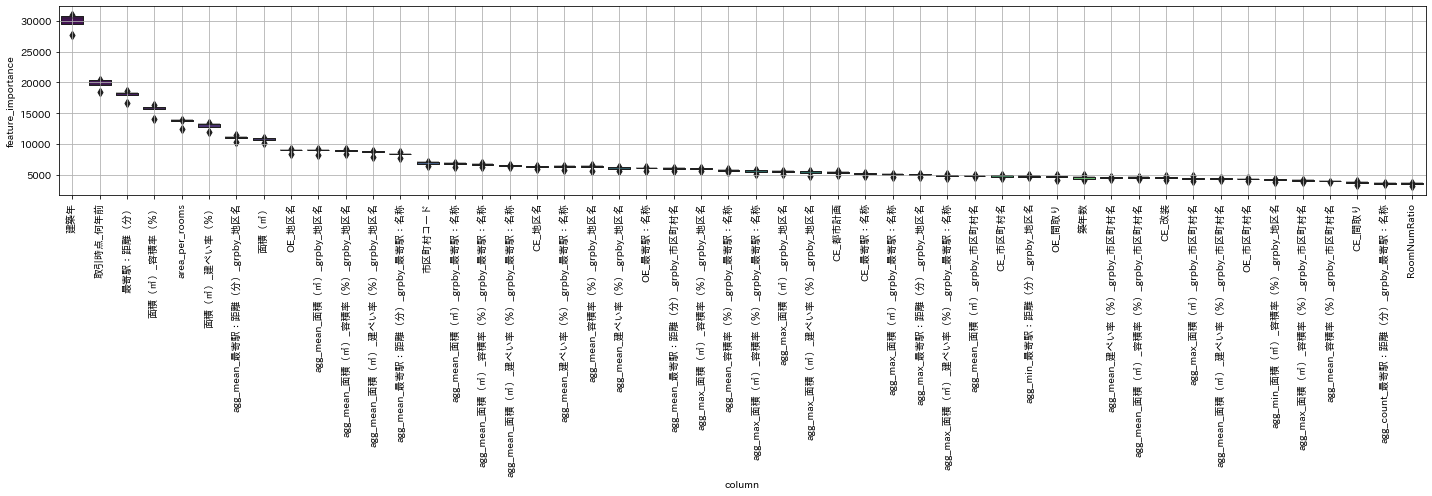

In [40]:
fig, ax = visualize_importance(models_default, train_x_default)

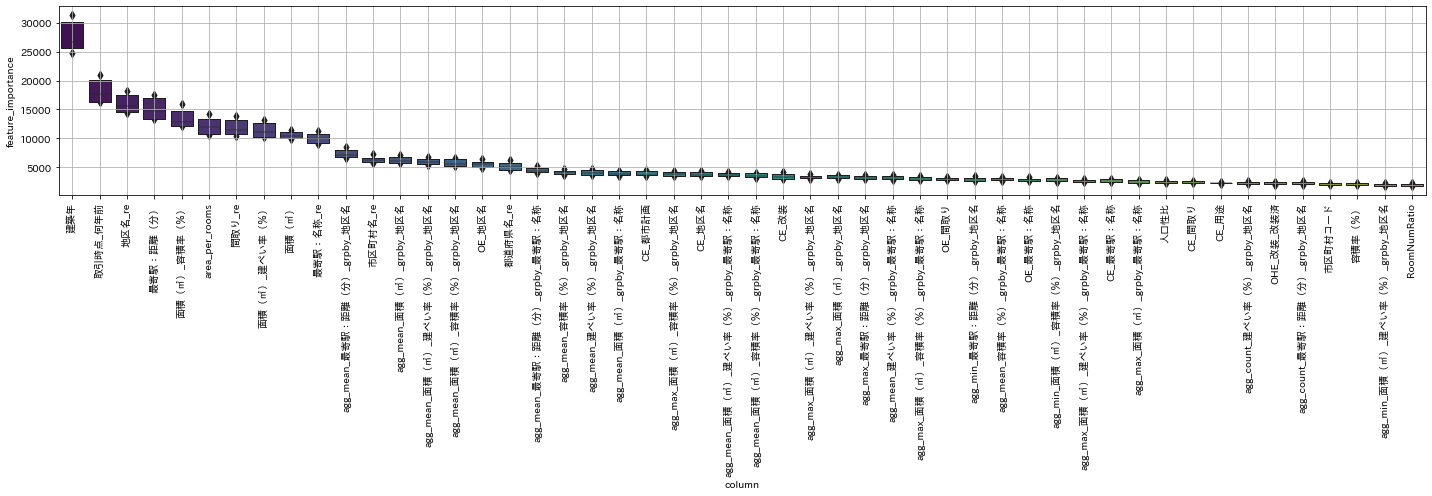

In [41]:
fig, ax = visualize_importance(models2, train_x_te)

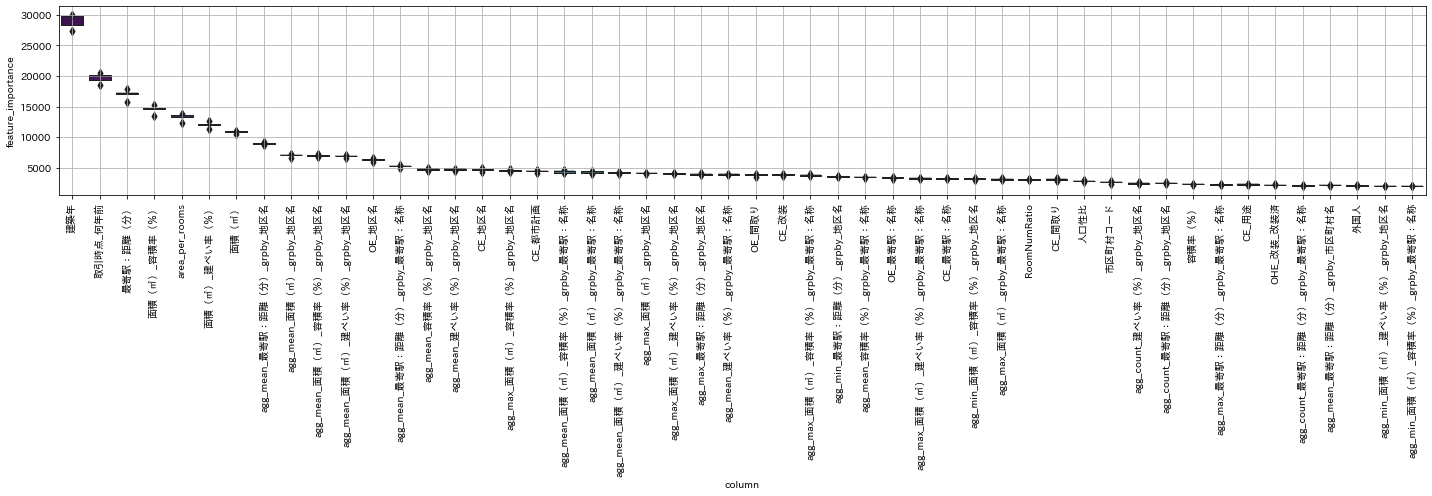

In [42]:
fig, ax = visualize_importance(models, train_x)

In [43]:
#oof_em = (oof_default+ oof+ oof2)/3
# 0.0718759237452052
oof_em = oof_default*0.2 +oof*0.4+oof2*0.4
oof_em2 = oof_cb_default*0.2+oof_cb*0.4+oof_cb_te*0.4
oof_em3 = oof_default*0.1 +oof*0.2+oof2*0.2 + oof_cb_default*0.1+oof_cb*0.2+oof_cb_te*0.2
metric_func = mean_absolute_error
print(metric_func(train_ys, oof_em3)) 

0.07044321738837568


# Pred_single model

In [44]:
pred_default = np.array([model.predict(test_x_default.values) for model in models_default])
pred_default = np.mean(pred_default, axis=0)
pred_default = np.where(pred_default < 0, 0, pred_default)
submission["取引価格（総額）_log"] = pred_default
submission.to_csv('simple_submission_default.csv', index=False)

In [45]:
pred1 = np.array([model.predict(test_x.values) for model in models])
pred1 = np.mean(pred1, axis=0)
pred1 = np.where(pred1 < 0, 0, pred1)
submission["取引価格（総額）_log"] = pred1
submission.to_csv('simple_submission1.csv', index=False)

In [46]:
pred2 = np.array([model.predict(test_x_te.values) for model in models2])
pred2 = np.mean(pred2, axis=0)
pred2 = np.where(pred2 < 0, 0, pred2)
submission["取引価格（総額）_log"] = pred2
submission.to_csv('simple_submission2.csv', index=False)

In [47]:
pred_cb = np.array([model.predict(test_x.values) for model in models_cb])
pred_cb = np.mean(pred_cb, axis=0)
pred_cb = np.where(pred_cb < 0, 0, pred_cb)
submission["取引価格（総額）_log"] = pred_cb
submission.to_csv('simple_submission_cb1.csv', index=False)

In [48]:
pred_cb_default = np.array([model.predict(test_x_default.values) for model in models_cb_default])
pred_cb_default = np.mean(pred_cb_default, axis=0)
pred_cb_default = np.where(pred_cb_default < 0, 0, pred_cb_default)

In [49]:
pred_cb_te = np.array([model.predict(test_x_te.values) for model in models_cb_te])
pred_cb_te = np.mean(pred_cb_te, axis=0)
pred_cb_te = np.where(pred_cb_te < 0, 0, pred_cb_te)

# pred_emsamble

In [50]:
#pred_em = (pred_default + pred1+pred2)/3
pred_em = pred_default*0.2 + pred1*0.4+pred2*0.4
pred_em2 = pred_cb_default*0.2+pred_cb*0.4+pred_cb_te*0.4
pred_em3 = pred_default*0.1 + pred1*0.2+pred2*0.2+pred_cb_default*0.1+pred_cb*0.2+pred_cb_te*0.2

In [51]:
submission["取引価格（総額）_log"] = pred_em3
submission.to_csv('simple_submission_em.csv', index=False)

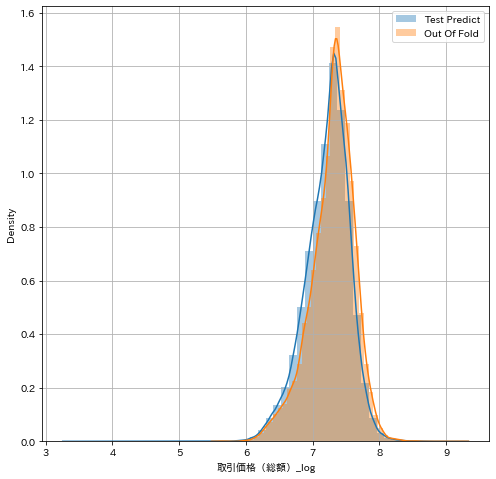

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(oof, label='Test Predict')
sns.distplot(submission["取引価格（総額）_log"], label='Out Of Fold')
ax.legend()
ax.grid()

# Stacking

In [53]:
stacking_train = pd.DataFrame({
    "lgb_default":oof_default,
    "lgb":oof,
    "lgb_TE":oof2,
    "Catboost_default":oof_cb_default,
    "Catboost":oof_cb,
    "Catboost_TE":oof_cb_te,
    "oof_em1":oof_em,
    "oof_em2":oof_em2,
    "oof_em3":oof_em3
})

stacking_test = pd.DataFrame({
    "lgb_default":pred_default,
    "lgb":pred1,
    "lgb_TE":pred2,
    "Catboost_default":pred_cb_default,
    "Catboost":pred_cb,
    "Catboost_TE":pred_cb_te,
    "oof_em1":pred_em,
    "oof_em2":pred_em2,
    "oof_em3":pred_em3
})

# 吐き出し
stacking_train.to_csv("stacking_train.csv", index=False)
stacking_test.to_csv("stacking_test.csv", index=False)

In [54]:
from sklearn import linear_model

def linear_fit(X, y, cv, params:dict=None, verbose: int=50):
    metric_func = mean_absolute_error
        # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        lin_model = linear_model.Ridge(**params)
        
        lin_model.fit(x_train, y_train)
        
        pred_i = lin_model.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(lin_model)

        print(f'Fold {i} MAE: {metric_func(y_valid, pred_i) :.4f}')

    score = metric_func(y, oof_pred) 
    print('FINISHED | Whole MAE: {:.4f}'.format(score))
    return oof_pred, models

In [55]:
fold = KFold(n_splits=10, shuffle=True, random_state=71)
cv = list(fold.split(stacking_train, train_ys))

lin_params = {
    'alpha': 80, 
    'fit_intercept': True,
    'max_iter': 8000, 
    'tol': 1e-04,
    'random_state': 71,
}

oof_stacking, models_stacking = linear_fit(stacking_train.values, train_ys, cv, lin_params)

Fold 0 MAE: 0.0707
Fold 1 MAE: 0.0702
Fold 2 MAE: 0.0698
Fold 3 MAE: 0.0712
Fold 4 MAE: 0.0712
Fold 5 MAE: 0.0714
Fold 6 MAE: 0.0713
Fold 7 MAE: 0.0711
Fold 8 MAE: 0.0702
Fold 9 MAE: 0.0711
FINISHED | Whole MAE: 0.0708


In [56]:
pred_stacking = np.array([model.predict(stacking_test.values) for model in models_stacking])
pred_stacking = np.mean(pred_stacking, axis=0)
pred_stacking = np.where(pred_stacking < 0, 0, pred_stacking)

In [57]:
submission["取引価格（総額）_log"] = pred_stacking
submission.to_csv('simple_submission_st.csv', index=False)

# CatBoost_stacking

In [58]:
params_cb_stack={
    'loss_function': 'MAE',
    'max_depth': 6, 
    'learning_rate': 0.03, 
    'subsample': 0.8, 
    'num_boost_round': 50000,
    'early_stopping_rounds': 100,
}

fold = KFold(n_splits=5, shuffle=True, random_state=23)
cv_stack = list(fold.split(stacking_train, train_ys))

oof_cb_st, models_cb_st =fit_cb(stacking_train.values, train_ys, cv_stack, params=params_cb_stack)

#0.0706

fit fold=1 213.333[s]
{'learn': {'MAE': 0.0698073169493747}, 'validation': {'MAE': 0.07093881432991753}}
Fold 0 MAE: 0.0709
fit fold=2 148.215[s]
{'learn': {'MAE': 0.07010771096956733}, 'validation': {'MAE': 0.07065089503767513}}
Fold 1 MAE: 0.0707
fit fold=3 145.105[s]
{'learn': {'MAE': 0.0700278082974175}, 'validation': {'MAE': 0.07000602083004884}}
Fold 2 MAE: 0.0700
fit fold=4 205.802[s]
{'learn': {'MAE': 0.07014018082722548}, 'validation': {'MAE': 0.07016784014945407}}
Fold 3 MAE: 0.0702
fit fold=5 141.433[s]
{'learn': {'MAE': 0.06999928037958812}, 'validation': {'MAE': 0.07090163008514928}}
Fold 4 MAE: 0.0709
FINISHED | Whole MAE: 0.0705


In [59]:
pred_stacking_cb = np.array([model.predict(stacking_test.values) for model in models_cb_st])
pred_stacking_cb= np.mean(pred_stacking_cb, axis=0)
pred_stacking_cb = np.where(pred_stacking_cb < 0, 0, pred_stacking_cb)

In [60]:
submission["取引価格（総額）_log"] = pred_stacking_cb
submission.to_csv('simple_submission_st_cb.csv', index=False)

# LGBM stacking

In [61]:
# テスト用のパラメータ
params_stacking = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.05,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 23,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

oof_lgb_st, models_lgb_st =fit_lgbm(stacking_train.values, train_ys, cv_stack, params=params_stacking)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 0.0747995
[100]	valid_0's l1: 0.0716533
[150]	valid_0's l1: 0.0716399
[200]	valid_0's l1: 0.0716441
Early stopping, best iteration is:
[138]	valid_0's l1: 0.0716386
fit fold=1 4.805[s]
Fold 0 MAE: 0.0716
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 0.0746661
[100]	valid_0's l1: 0.0713155
[150]	valid_0's l1: 0.0712926
[200]	valid_0's l1: 0.0712966
Early stopping, best iteration is:
[139]	valid_0's l1: 0.0712905
fit fold=2 4.603[s]
Fold 1 MAE: 0.0713
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 0.0738253
[100]	valid_0's l1: 0.0706966
[150]	valid_0's l1: 0.070683
[200]	valid_0's l1: 0.0706844
[250]	valid_0's l1: 0.0706918
Early stopping, best iteration is:
[178]	valid_0's l1: 0.0706803
fit fold=3 5.399[s]
Fold 2 MAE: 0.0707
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 0.0741943
[100]	valid_0's l1: 0

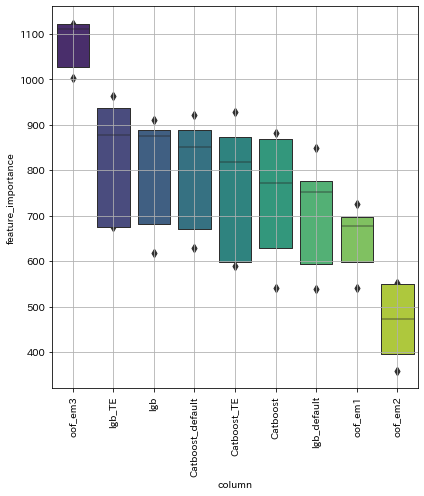

In [63]:
fig, ax = visualize_importance(models_lgb_st, stacking_train)

# DNN regressor

In [85]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [100]:
# ここの設定を怠ったから再現性担保できなかった。
import os
import random

def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [101]:
dnn_y = train_ys.values.reshape(-1,1)

In [102]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()

In [103]:
normalizer.adapt(np.array(stacking_train))

In [104]:
set_seed(0)
model_dnn = tf.keras.Sequential([
    tf.keras.layers.Input((None,9,)),
    normalizer,
    tf.keras.layers.Dense(81, activation='relu'), 
    tf.keras.layers.Dense(45, activation='relu'), 
    tf.keras.layers.Dense(18, activation='relu'),
    tf.keras.layers.Dense(1)
   ])

In [105]:
model_dnn.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.001, nesterov=True),
             loss=tf.keras.losses.mean_absolute_error)

In [106]:
model_dnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, None, 9)           19        
_________________________________________________________________
dense_16 (Dense)             (None, None, 81)          810       
_________________________________________________________________
dense_17 (Dense)             (None, None, 45)          3690      
_________________________________________________________________
dense_18 (Dense)             (None, None, 18)          828       
_________________________________________________________________
dense_19 (Dense)             (None, None, 1)           19        
Total params: 5,366
Trainable params: 5,347
Non-trainable params: 19
_________________________________________________________________


In [107]:
x_train, x_valid, y_train, y_valid = train_test_split(stacking_train, dnn_y, train_size=0.8, random_state=0)

In [108]:
#history = model_dnn.fit(stacking_train, dnn_y, validation_split=0.2, epochs=50)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

history = model_dnn.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, callbacks=[early_stop])

Epoch 1/100


14343/15934 [==========================>...] - ETA: 0s - loss: 7.416 - ETA: 16s - loss: 6.27 - ETA: 18s - loss: 4.85 - ETA: 19s - loss: 3.89 - ETA: 18s - loss: 3.05 - ETA: 18s - loss: 2.44 - ETA: 19s - loss: 2.17 - ETA: 19s - loss: 1.91 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.55 - ETA: 18s - loss: 1.41 - ETA: 19s - loss: 1.32 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.17 - ETA: 19s - loss: 1.10 - ETA: 19s - loss: 1.04 - ETA: 19s - loss: 0.99 - ETA: 19s - loss: 0.95 - ETA: 18s - loss: 0.90 - ETA: 18s - loss: 0.86 - ETA: 18s - loss: 0.83 - ETA: 18s - loss: 0.80 - ETA: 18s - loss: 0.76 - ETA: 17s - loss: 0.73 - ETA: 17s - loss: 0.70 - ETA: 17s - loss: 0.69 - ETA: 17s - loss: 0.67 - ETA: 17s - loss: 0.65 - ETA: 17s - loss: 0.63 - ETA: 17s - loss: 0.61 - ETA: 17s - loss: 0.60 - ETA: 17s - loss: 0.58 - ETA: 17s - loss: 0.57 - ETA: 16s - loss: 0.56 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.54 - ETA: 16s - loss: 0.53 - ETA: 16s - loss: 0.52 - ETA: 16s - loss: 0.51 - ETA: 16s - loss: 

15934/15934 [==============================] - 21s 1ms/step - loss: 0.1397 - val_loss: 0.0707
Epoch 2/100


15243/15934 [===========================>..] - ETA: 1s - loss: 0.066 - ETA: 25s - loss: 0.08 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - 20s 1ms/step - loss: 0.0767 - val_loss: 0.0725
Epoch 3/100


14939/15934 [===========================>..] - ETA: 0s - loss: 0.104 - ETA: 21s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.074 - ETA: 1s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - 20s 1ms/step - loss: 0.0747 - val_loss: 0.0876
Epoch 4/100
15934/15934 [==============================] - ETA: 2s - loss: 0.061 - ETA: 27s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21

15934/15934 [==============================] - ETA: 2s - loss: 0.068 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.064 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.067 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 

15934/15934 [==============================] - ETA: 4s - loss: 0.075 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 

15934/15934 [==============================] - ETA: 3s - loss: 0.100 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.056 - ETA: 25s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.060 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0729 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.073 - ETA: 9s - loss: 0.073 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.053 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0727 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 4s - loss: 0.089 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0732 - ETA: 9s - loss: 0.073 - ETA: 9s - loss: 0.073 - ETA: 9s - loss: 0.073 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.091 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0726 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.053 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0727 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.069 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0727 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.084 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0725 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.060 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0727 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.073 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.085 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0723 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.079 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0725 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.098 - ETA: 16s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.085 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0724 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 10s - loss:

15934/15934 [==============================] - ETA: 0s - loss: 0.052 - ETA: 18s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 27s - loss: 0.07 - ETA: 27s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 27s - loss: 0.07 - ETA: 27s - loss: 0.07 - ETA: 27s - loss: 0.07 - ETA: 27s - loss: 0.07 - ETA: 27s - loss: 0.07 - ETA: 28s - loss: 0.07 - ETA: 28s - loss: 0.07 - ETA: 28s - loss: 0.07 - ETA: 28s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.049 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0723 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.062 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 

15934/15934 [==============================] - ETA: 2s - loss: 0.072 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.089 - ETA: 26s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.070 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.089 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0717 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.056 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0711 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.064 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0730 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 0.072 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 3s - loss: 0.065 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0711 - ETA: 9s - loss: 0.071 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0710 - ETA: 9s - loss: 0.071 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0711 - ETA: 9s - loss: 0.071 - ETA: 9s - loss

15934/15934 [==============================] - ETA: 1s - loss: 0.072 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0719 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.083 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 

15934/15934 [==============================] - ETA: 4s - loss: 0.073 - ETA: 17s - loss: 0.06 - ETA: 16s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 22s - loss: 0.06 - ETA: 21s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.049 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.079 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.059 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.059 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.075 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 

13459/15934 [========================>.....] - ETA: 0s - loss: 0.056 - ETA: 3:24 - loss: 0.087 - ETA: 1:25 - loss: 0.071 - ETA: 50s - loss: 0.071 - ETA: 42s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 32s - loss: 0.07 - ETA: 30s - loss: 0.07 - ETA: 29s - loss: 0.07 - ETA: 27s - loss: 0.07 - ETA: 27s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - l

15934/15934 [==============================] - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0

13013/15934 [=======================>......] - ETA: 0s - loss: 0.085 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 

15934/15934 [==============================] - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0

15934/15934 [==============================] - ETA: 7s - loss: 0.112 - ETA: 11s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.063 - ETA: 11s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 16s - loss: 0.06 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.049 - ETA: 21s - loss: 0.06 - ETA: 29s - loss: 0.07 - ETA: 31s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.090 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0710 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.062 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 15s - loss: 0.06 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.072 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 

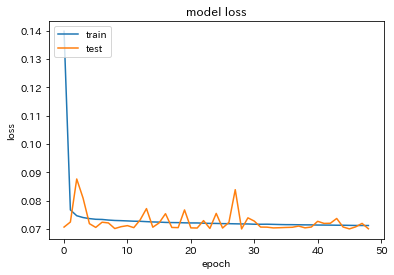

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [112]:
model_dnn.evaluate(stacking_train, dnn_y)

19918/19918 [==============================] - ETA: 2s - loss: 0.114 - ETA: 16s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 

0.07020355761051178

In [113]:
predictions_dnn = model_dnn.predict(stacking_test)

In [114]:
submission_dnn = submission["ID"]
submission_dnn = pd.concat([submission_dnn, pd.DataFrame(data=predictions_dnn, columns=["取引価格（総額）_log"])], axis=1)

In [115]:
submission_dnn.to_csv('simple_submission_st_dnn.csv', index=False)

In [78]:
# dnn2

model_dnn2 = tf.keras.Sequential([
    tf.keras.layers.Input((None,9,)),
    normalizer,
    tf.keras.layers.Dense(90, activation='relu'), 
    tf.keras.layers.Dense(72, activation='relu'), 
    tf.keras.layers.Dense(54, activation='relu'), 
    tf.keras.layers.Dense(45, activation='relu'), 
    tf.keras.layers.Dense(27, activation='relu'),
    tf.keras.layers.Dense(18, activation='relu'),
    tf.keras.layers.Dense(9, activation='relu'),
    tf.keras.layers.Dense(1)
   ])

In [79]:
model_dnn2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.001, nesterov=True),
             loss=tf.keras.losses.mean_absolute_error)

In [80]:
model_dnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, None, 9)           19        
_________________________________________________________________
dense_4 (Dense)              (None, None, 90)          900       
_________________________________________________________________
dense_5 (Dense)              (None, None, 72)          6552      
_________________________________________________________________
dense_6 (Dense)              (None, None, 54)          3942      
_________________________________________________________________
dense_7 (Dense)              (None, None, 45)          2475      
_________________________________________________________________
dense_8 (Dense)              (None, None, 27)          1242      
_________________________________________________________________
dense_9 (Dense)              (None, None, 18)         

In [81]:
history2 = model_dnn2.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, callbacks=[early_stop])

Epoch 1/100


11555/15934 [====================>.........] - ETA: 0s - loss: 7.336 - ETA: 24s - loss: 7.06 - ETA: 40s - loss: 7.02 - ETA: 35s - loss: 6.88 - ETA: 32s - loss: 6.72 - ETA: 29s - loss: 6.54 - ETA: 30s - loss: 6.43 - ETA: 28s - loss: 6.26 - ETA: 28s - loss: 6.09 - ETA: 27s - loss: 5.91 - ETA: 26s - loss: 5.71 - ETA: 26s - loss: 5.58 - ETA: 27s - loss: 5.47 - ETA: 26s - loss: 5.28 - ETA: 25s - loss: 5.07 - ETA: 24s - loss: 4.84 - ETA: 24s - loss: 4.63 - ETA: 23s - loss: 4.42 - ETA: 23s - loss: 4.21 - ETA: 22s - loss: 4.02 - ETA: 23s - loss: 3.86 - ETA: 22s - loss: 3.69 - ETA: 22s - loss: 3.50 - ETA: 22s - loss: 3.35 - ETA: 22s - loss: 3.22 - ETA: 22s - loss: 3.12 - ETA: 22s - loss: 3.03 - ETA: 22s - loss: 2.94 - ETA: 22s - loss: 2.85 - ETA: 22s - loss: 2.76 - ETA: 22s - loss: 2.71 - ETA: 23s - loss: 2.67 - ETA: 23s - loss: 2.63 - ETA: 23s - loss: 2.56 - ETA: 23s - loss: 2.48 - ETA: 23s - loss: 2.40 - ETA: 23s - loss: 2.33 - ETA: 23s - loss: 2.29 - ETA: 23s - loss: 2.26 - ETA: 23s - loss: 

15934/15934 [==============================] - 24s 2ms/step - loss: 0.2377 - val_loss: 0.0708
Epoch 2/100


14771/15934 [==========================>...] - ETA: 0s - loss: 0.077 - ETA: 26s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 21s 1ms/step - loss: 0.0715 - val_loss: 0.0714
Epoch 3/100


14664/15934 [==========================>...] - ETA: 2s - loss: 0.053 - ETA: 36s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 21s 1ms/step - loss: 0.0714 - val_loss: 0.0743
Epoch 4/100


14174/15934 [=========================>....] - ETA: 2s - loss: 0.061 - ETA: 25s - loss: 0.06 - ETA: 21s - loss: 0.06 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 

15934/15934 [==============================] - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0

14426/15934 [==========================>...] - ETA: 1s - loss: 0.061 - ETA: 24s - loss: 0.07 - ETA: 21s - loss: 0.06 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 21s 1ms/step - loss: 0.0712 - val_loss: 0.0744
Epoch 6/100


14357/15934 [==========================>...] - ETA: 2s - loss: 0.066 - ETA: 27s - loss: 0.06 - ETA: 22s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 21s 1ms/step - loss: 0.0712 - val_loss: 0.0703
Epoch 7/100


15381/15934 [===========================>..] - ETA: 0s - loss: 0.094 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 20s 1ms/step - loss: 0.0712 - val_loss: 0.0705
Epoch 8/100


14694/15934 [==========================>...] - ETA: 0s - loss: 0.054 - ETA: 20s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 21s 1ms/step - loss: 0.0711 - val_loss: 0.0709
Epoch 9/100


14342/15934 [==========================>...] - ETA: 0s - loss: 0.090 - ETA: 23s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 21s 1ms/step - loss: 0.0711 - val_loss: 0.0710
Epoch 10/100


14181/15934 [=========================>....] - ETA: 0s - loss: 0.077 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 

15934/15934 [==============================] - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0

15303/15934 [===========================>..] - ETA: 0s - loss: 0.099 - ETA: 32s - loss: 0.06 - ETA: 27s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 20s 1ms/step - loss: 0.0711 - val_loss: 0.0711
Epoch 12/100


14808/15934 [==========================>...] - ETA: 1s - loss: 0.067 - ETA: 29s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 21s 1ms/step - loss: 0.0711 - val_loss: 0.0702
Epoch 13/100


14247/15934 [=========================>....] - ETA: 0s - loss: 0.045 - ETA: 27s - loss: 0.06 - ETA: 22s - loss: 0.07 - ETA: 21s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 21s 1ms/step - lo

14198/15934 [=========================>....] - ETA: 0s - loss: 0.087 - ETA: 23s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 

15934/15934 [==============================] - ETA: 2s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 21s 1ms/step - lo

14212/15934 [=========================>....] - ETA: 0s - loss: 0.093 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 

15934/15934 [==============================] - ETA: 2s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0

14439/15934 [==========================>...] - ETA: 0s - loss: 0.064 - ETA: 24s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 21s 1ms/step - loss: 0.0710 - val_loss: 0.0708
Epoch 17/100


15934/15934 [==============================] - ETA: 0s - loss: 0.062 - ETA: 27s - loss: 0.06 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 

15815/15934 [============================>.] - ETA: 0s - loss: 0.097 - ETA: 25s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 16s - loss: 0.06 - ETA: 16s - loss: 0.06 - ETA: 16s - loss: 0.06 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - 19s 1ms/step - loss: 0.0710 - val_loss: 0.0703
Epoch 19/100


14264/15934 [=========================>....] - ETA: 1s - loss: 0.099 - ETA: 23s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - 21s 1ms/step - lo

13671/15934 [========================>.....] - ETA: 2s - loss: 0.061 - ETA: 29s - loss: 0.06 - ETA: 24s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 

15934/15934 [==============================] - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0

13950/15934 [=========================>....] - ETA: 2s - loss: 0.090 - ETA: 26s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 

15934/15934 [==============================] - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.071 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0

10314/15934 [==================>...........] - ETA: 1s - loss: 0.071 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 16s - loss: 0.06 - ETA: 16s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 

15934/15934 [==============================] - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.071 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.071 - ETA: 8s - loss: 0.071 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.071 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 7s - loss: 0

15934/15934 [==============================] - ETA: 2s - loss: 0.098 - ETA: 19s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 21s - loss: 0.06 - ETA: 23s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 25s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 0.07 - ETA: 26s - loss: 

15235/15934 [===========================>..] - ETA: 0s - loss: 0.053 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 

15934/15934 [==============================] - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - 21s 1ms/step - loss: 0.0709 - val_loss: 0.0708
Epoch 25/100


15933/15934 [============================>.] - ETA: 1s - loss: 0.053 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 20s - loss: 0.06 - ETA: 23s - loss: 0.06 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.06 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.06 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 

15934/15934 [==============================] - 19s 1ms/step - loss: 0.0709 - val_loss: 0.0710
Epoch 26/100


14248/15934 [=========================>....] - ETA: 0s - loss: 0.068 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 

15934/15934 [==============================] - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 1s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0.070 - ETA: 0s - loss: 0

Epoch 28/100
15934/15934 [==============================] - ETA: 0s - loss: 0.071 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA:

13002/15934 [=======================>......] - ETA: 0s - loss: 0.076 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 

15934/15934 [==============================] - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0

11886/15934 [=====================>........] - ETA: 0s - loss: 0.082 - ETA: 47s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 32s - loss: 0.07 - ETA: 28s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 24s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 

15934/15934 [==============================] - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0

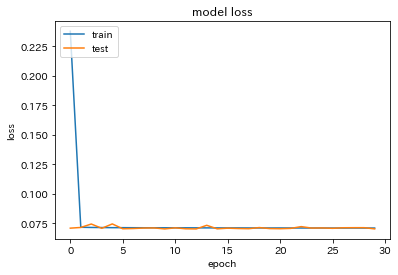

In [82]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
model_dnn2.evaluate(stacking_train, dnn_y)

19918/19918 [==============================] - ETA: 2s - loss: 0.114 - ETA: 15s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 

0.07028379291296005

In [84]:
predictions_dnn2 = model_dnn2.predict(stacking_test)

submission_dnn2 = submission["ID"]
submission_dnn2 = pd.concat([submission_dnn2, pd.DataFrame(data=predictions_dnn2, columns=["取引価格（総額）_log"])], axis=1)

submission_dnn2.to_csv('simple_submission_st_dnn2.csv', index=False)

# stacking_emsanble_means

In [176]:
submission_st_em = submission_dnn.copy()
submission_st_em["dnn2"] = submission_dnn2["取引価格（総額）_log"]
submission_st_em["cat_st"] = pred_stacking_cb
submission_st_em["avg"] = (submission_st_em["取引価格（総額）_log"]*0.4 + submission_st_em["dnn2"]*0.4+submission_st_em["cat_st"]*0.2)
submission["取引価格（総額）_log"] = submission_st_em["avg"]
submission.to_csv('simple_submission_em_st.csv', index=False)

# これが最新！

In [152]:
#submission["取引価格（総額）_log"] = pred_em_st
#submission.to_csv('simple_submission_em_st.csv', index=False)

In [109]:
# スタッキングデータだけ保存する
stacking_train_output  = stacking_train.copy()
stacking_train_output["y"] = train_ys
stacking_train_output.to_csv("stacking_train.csv")

In [110]:
stacking_train_output

,lgb_default,lgb,lgb_TE,Catboost_default,Catboost,Catboost_TE,oof_em1,oof_em2,oof_em3,y
0,7.235750,7.219677,7.217058,7.233613,7.223696,7.224238,7.221844,7.225896,7.223870,7.230449
1,7.038051,6.993963,7.047839,7.068626,7.074256,7.084898,7.024331,7.077387,7.050859,6.875061
2,7.121183,7.126289,7.124848,7.097916,7.112526,7.124333,7.124691,7.114327,7.119509,7.041393
3,7.051580,7.060517,7.070309,7.044212,7.043337,7.082527,7.062646,7.059188,7.060917,7.041393
4,7.974474,8.011260,8.037964,7.976155,7.943011,7.984484,8.014585,7.966229,7.990407,8.000000
...,...,...,...,...,...,...,...,...,...,...
637346,7.111367,7.092678,7.095846,7.075609,7.084067,7.072504,7.097683,7.077750,7.087717,7.113943
637347,7.313398,7.314174,7.313270,7.349903,7.356654,7.317061,7.313657,7.339467,7.326562,7.041393
637348,7.242456,7.282497,7.249943,7.255329,7.258747,7.254298,7.261467,7.256284,7.258876,7.230449
637349,7.298889,7.317625,7.318837,7.349538,7.327457,7.312625,7.314363,7.325941,7.320152,7.322219
